## Problem Statement

When engaging with content in our model world, corporations use recommender system to suggest future content we might like based on the attributes of the content. Be it movies or books that we may be interested in with the goal of keeping customer interested andf However this may cause an echo chamber effect.

An extreme example of an echo chamber caused by recommender system is youtube's algorithm suggesting alt-right content which may lead to an individual developing extremist views. And this a problem of overtraining, because what is recommended is based on the data that is inputed to the system. 

Spotify uses a common method for producing recommendations known as collaborative filtering which generates recommendations based on the combined preferences of the consumer requesting recommendations and those of other consumers. The underlying issue with this method is that song recommendations are based on the 'crowd'.

Furthermore, as the business model of Spotify is built in a way where artists are compensated by number of streams, the homegenization of new music become more prevalent. Such as making songs more catchier and shorter. 

The recommender system I would like to propose is for users to be recommended songs based on the 'DNA' of the music they have been listening to with the goal of potentially exposing the listener to songs form different genres and epochs. This is threfore a cluster or nearest neighbour recommendation system. This would broaden the horizon of music listeners and also bring attention to artists that create music as an artform as opposed to achieving the highest streaming numbers. 

In this notebook, EDA specific to my problem statement would be explored.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

from numpy import dot
from numpy.linalg import norm


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

plt.style.use('fivethirtyeight')



# Datasets for Artist information (from Spotify Songs Kaggle dataset)

## Data Dictionary

2 datasets that are used from Kaggle, 'data_o' and 'data_by_year_o'.

|variable                 |datatype     |description |
|:---|:---|:-----------|
|id                 |object | Song unique ID|
|name               |object | Song Name|
|artist             |object | Song Artist|
|popularity         |int64    | Song Popularity (0-100) where higher is better |
|danceability             |float64  | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
|energy                   | float64  | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
|key                      |int64    | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
|loudness                 |float64    | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.|
|mode                     |int64  | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.|
|speechiness              |float64    | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
|acousticness             |float64   | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.|
|instrumentalness         |float64   | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
|liveness                 |float64    | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
|valence                  |float64    | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
|tempo                    |float64    | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |
|duration_ms              |int64   | Duration of song in milliseconds |

## Import Datasets

In [3]:
data_df = pd.read_csv('../data/spotify_songs_1922/data_o.csv')
data_by_year_df = pd.read_csv('../data/spotify_songs_1922/data_by_year_o.csv')

## Data Cleaning

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [5]:
#inspect general distribution of each feature
data_df.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


observation: the longest song duration in the dataset shows to be 90 minutes long. These are likely to be podcast are maybe comedy albums that comedians have put out. Or could also be audio of soundscapes people use for mediation. Ultimately for my project, with the knowledge that most popular songs are under 10 minutes. I would remove all songs that exceed this duration. 

In [6]:
print(f"Number of songs that were over 10 minutes: {len(data_df[data_df.duration_ms > 600000].index)}")

Number of songs that were over 10 minutes: 2265


In [7]:
#drop songs that are over 10 minutes
data_df = data_df.drop(data_df[data_df.duration_ms > 600000].index)
#reset index
data_df.reset_index(drop = True,inplace = True)

### Check for duplicates

In [8]:
data_df.tail()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
168383,0.608,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
168384,0.734,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
168385,0.637,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
168386,0.195,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055
168387,0.642,2020,0.13200,"['KEVVO', 'J Balvin']",0.856,189507,0.721,1,7HmnJHfs0BkFzX4x8j0hkl,0.004710,7,0.1820,-4.928,1,Billetes Azules (with J Balvin),74,2020-10-16,0.1080,94.991


In [9]:
data_df[data_df['artists'].str.contains("Drake")].head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
4163,0.361,1943,0.975,"['Alfred Drake', 'Oklahoma Chorus']",0.400,152120,0.308,0,18Lxour9k0zowOzlPIrlPF,0.000412,3,0.0807,-10.749,1,"Oh, What A Beautiful Mornin'",19,1943-12-02,0.0389,81.336
4166,0.765,1943,0.887,"['Alfred Drake', 'Oklahoma Chorus']",0.672,150493,0.441,0,1gmK889zKeVBpdmkv0hv4N,0.000000,6,0.1220,-10.989,0,Oklahoma,16,1943-12-02,0.1700,68.552
4185,0.184,1943,0.940,"['Alfred Drake', 'Joan Roberts']",0.349,190053,0.159,0,1HuIThAQ9aWdUJ2118ov8i,0.000000,1,0.1800,-12.689,1,People Will Say We're In Love,9,1943-12-02,0.0379,78.985
4197,0.377,1943,0.918,['Alfred Drake'],0.571,187013,0.155,0,3vSsJRF0UIlR7DAT6aS9nW,0.000000,9,0.1260,-12.843,1,The Surrey With The Fringe On Top,7,1943-12-02,0.0871,80.847
4217,0.279,1943,0.873,"['Alfred Drake', 'Howard Da Silva']",0.399,169667,0.160,0,1TIzYuKM2ZzznANW4q9axG,0.000000,4,0.1850,-13.306,1,Pore Jud Is Daid,3,1943-12-02,0.0347,135.557


### data_df

In [10]:
# check for Ashnikko result for the Song 'Daisy' in data_df dataset
data_df[(data_df.artists == "['Ashnikko']") & (data_df.name == "Daisy")]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
19490,0.774,2020,0.235,['Ashnikko'],0.834,146523,0.663,1,0AUvWawuP0ibk4SQ3sIZjk,0.0,8,0.372,-6.143,1,Daisy,90,2020-07-09,0.133,121.876


In [11]:
# check for Drake result for the Song 'Daisy' in data_df dataset
data_df[(data_df.artists == "['Drake']") & (data_df.name == "Best I Ever Had")]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
17272,0.558,2009,0.1900,['Drake'],0.395,257690,0.922,1,3QLjDkgLh9AOEHlhQtDuhs,0.0,1,0.134,-2.176,1,Best I Ever Had,73,2009,0.375,162.361
17648,0.605,2010,0.0951,['Drake'],0.431,258760,0.894,1,1GxHeBvQ9935Dd3cSfsfBa,0.0,5,0.188,-2.673,0,Best I Ever Had,63,2010-01-01,0.330,162.161


comments: For the example above, the same song had more than 1 output. For Data_df their release year and date is different as well as some attributes such as 'danceability'. This may indicate that the song was release twice, perhaps the latter was remastered and released in an album and not just as a single like the first time. 

Will investigate on more time. With the classic song "Here Comes the Sun" by the Beatles.

In [12]:
# check for Beatles result for the Song 'Here Comes the Sun' in data_df dataset
data_df[(data_df.artists == "['The Beatles']") & (data_df.name == "Here Comes The Sun")]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo


comment: No song to be found, however the remastered version is available.

In [13]:
# check for Beatles result for the Song 'Here Comes the Sun' in data_df dataset
data_df[(data_df.artists == "['The Beatles']") & (data_df.name == "Here Comes The Sun - Remastered 2009")]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
9282,0.394,1969,0.0339,['The Beatles'],0.557,185733,0.540,0,6dGnYIeXmHdcikdzNNDMm2,0.00248,9,0.179,-10.484,1,Here Comes The Sun - Remastered 2009,82,1969-09-26,0.0347,129.171
64872,0.371,1973,0.0362,['The Beatles'],0.557,187373,0.519,0,5bIEpKwEFgJzB7U3gFaeKm,0.00126,9,0.105,-11.164,1,Here Comes The Sun - Remastered 2009,40,1973-04-02,0.0357,129.157


Comments: For this song only the remastered version is available on spotify, and they still appear to have different characteristics, such as popularity, duration and energy.

Difference in popularity can be explained by the song being in an album that may have not been marketed as well or listeners feel that that album does not have other songs they would enjoy. For example the song that had a lower popularity score belonged to the album 'The Beatles 1967-1970' whereas the song with the higher popularity had belonged to the album 'Abbey Road (remasted)' where its a bigger compliation of classic by the band. 


#### Conclusion

Datasets that would be used for EDA would be data_by_year_df.

In terms of duplicates as one song is the remastered version of the other. By definition, remastering music is essentially improving on the quality of the original copy of a song or album. Removing flaws from the music, providing a cleaner, sharper and more refined listening experience whilst trying to bringing the music up to date with current standard. After remastering, certain attributes of the song would still generally remain the same, such as key, time signature, duration, tempo and speechiness. Nonetheless these duplicates, I would not remove them, as there are some music enthusiast that actually prefered 'non tampered' music. However I would remove songs that are duplicates where they have the same exact, values in terms of audio features. These are songs that appear multiple times in different albums.


In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168388 entries, 0 to 168387
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           168388 non-null  float64
 1   year              168388 non-null  int64  
 2   acousticness      168388 non-null  float64
 3   artists           168388 non-null  object 
 4   danceability      168388 non-null  float64
 5   duration_ms       168388 non-null  int64  
 6   energy            168388 non-null  float64
 7   explicit          168388 non-null  int64  
 8   id                168388 non-null  object 
 9   instrumentalness  168388 non-null  float64
 10  key               168388 non-null  int64  
 11  liveness          168388 non-null  float64
 12  loudness          168388 non-null  float64
 13  mode              168388 non-null  int64  
 14  name              168388 non-null  object 
 15  popularity        168388 non-null  int64  
 16  release_date      16

In [15]:
#put all audio features into list
audio_features = ['tempo','speechiness','speechiness','mode','loudness','liveness','key','instrumentalness','energy','danceability','acousticness','valence']

In [18]:
#get array of index to drop
duplicate_rows = data_df[data_df.duplicated(subset=audio_features, keep='first')].index

In [19]:
#drop duplicated rows and reset index
data_df.drop(duplicate_rows,inplace=True)
data_df.reset_index(drop=True, inplace=True)

In [20]:
#drop rows that also have the same artist and song title incase they happen to have different audio features. remastered songs tend to have 'remastered' in its name
duplicate_name_rows = data_df[data_df.duplicated(subset=['name','artists'], keep='first')].index

In [21]:
#drop duplicated rows and reset index
data_df.drop(duplicate_name_rows,inplace=True)
data_df.reset_index(drop=True, inplace=True)

### Reformmating Artist Column

I had observed earlier that artists seem to be in lists in artist column in data_df

In [22]:
data_df.artists[15]

"['Phil Regan']"

In [23]:
data_df.artists[15][0] #check to see if it is a list

'['

As we can see from above, it was a list, 'Sergio Racmaninoff' would have been returned.

artist and genre columns, they are actually not list, but strings that look like list. 
we shall therefore use a function to transform these elements into cleaned string.

In [24]:
"""function to transfor string
list into actual string """

def clean_string_main_artist(x):
    #remove square brackets
    x = x.replace('[','')
    x = x.replace(']','')
    
    #making into list by spliting at comma
    list_of_artist = x.split(", ")
    
    #transform individual elements 
    for artist in range(len(list_of_artist)):
        list_of_artist[artist] = list_of_artist[artist].replace("'","")  
    
    #return the main artist in the list, main artist are the first in the list and the featuring artist are artist proceeding
    return list_of_artist[0]

In [25]:
data_df['main_artist'] = data_df['artists'].apply(lambda x: clean_string_main_artist(x))

In [26]:
data_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist
0,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day
1,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...
2,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Frank Parker
3,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan
4,0.1960,1921,0.579,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.697,395076,0.346,0,4pyw9DVHGStUre4J6hPngr,0.168000,2,0.130,-12.506,1,Gati Mardika,6,1921,0.0700,119.824,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...


In [27]:
"""function to transfor string
list into actual string """

def clean_string_featuring_artist(x):
    #remove square brackets
    x = x.replace('[','')
    x = x.replace(']','')
    
    #making into list by spliting at comma
    list_of_artist = x.split(", ")
    
    #transform individual elements 
    for artist in range(len(list_of_artist)):
        list_of_artist[artist] = list_of_artist[artist].replace("'","")  
    
    #return featuring artist are artist proceeding
    return list_of_artist[1:]

In [28]:
data_df['feat_artist'] = data_df['artists'].apply(lambda x: clean_string_featuring_artist(x))

In [29]:
data_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist,feat_artist
0,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day,[]
1,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]
2,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Frank Parker,[]
3,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan,[]
4,0.1960,1921,0.579,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.697,395076,0.346,0,4pyw9DVHGStUre4J6hPngr,0.168000,...,0.130,-12.506,1,Gati Mardika,6,1921,0.0700,119.824,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]


## Exploratory Data Analysis

In [30]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155098 entries, 0 to 155097
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           155098 non-null  float64
 1   year              155098 non-null  int64  
 2   acousticness      155098 non-null  float64
 3   artists           155098 non-null  object 
 4   danceability      155098 non-null  float64
 5   duration_ms       155098 non-null  int64  
 6   energy            155098 non-null  float64
 7   explicit          155098 non-null  int64  
 8   id                155098 non-null  object 
 9   instrumentalness  155098 non-null  float64
 10  key               155098 non-null  int64  
 11  liveness          155098 non-null  float64
 12  loudness          155098 non-null  float64
 13  mode              155098 non-null  int64  
 14  name              155098 non-null  object 
 15  popularity        155098 non-null  int64  
 16  release_date      15

### creating scaled dataframe for eda

In [32]:
#scale data for line graph to observe any trends worth noting
lin_graph = data_by_year_df.iloc[:,2:]
ss = StandardScaler()
lin_graph_data = ss.fit_transform(lin_graph)

In [34]:
#put line graph data into dataframe
lin_graph_data = pd.DataFrame(data = lin_graph_data, columns=data_by_year_df.iloc[:,2:].columns.values)

In [35]:
#concat graph data with year column
graph_data = pd.concat([lin_graph_data,data_by_year_df.year],axis=1)

In [36]:
graph_data

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,year
0,1.206593,-2.268729,1.303465,-1.372612,1.241416,-0.141117,-1.643865,-0.394037,-2.567559,-2.656372,-1.297256,-0.504959,1921
1,1.395278,-1.050819,-2.424439,-1.335327,1.974278,1.824215,-2.364442,0.132090,-2.682246,0.059618,-1.322135,1.751841,1922
2,1.463369,0.778558,-1.935347,-1.182517,1.461764,1.079979,-0.699070,-0.145779,-0.355409,1.623313,-1.067354,-1.069159,1923
3,1.401148,0.251686,-1.421483,-0.673342,3.184595,1.515427,-0.732122,-0.168531,0.828525,2.288008,-1.296883,1.751841,1924
4,1.482933,0.711808,-1.659106,-1.081931,1.843836,1.652901,-0.704637,0.074121,-0.087526,1.561357,-1.202546,0.341341,1925
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.993316,1.217422,-0.231368,0.870891,-0.817217,-1.518719,1.264707,-0.018941,0.467444,-1.748761,1.566603,-1.069159,2016
96,-0.986279,1.448058,-0.634512,0.855765,-0.791730,-0.926886,1.183293,0.057215,0.210427,-2.010511,1.742160,-0.787059,2017
97,-1.053679,2.432513,-0.835076,0.930417,-1.143516,-1.790666,1.553464,0.260836,1.047048,-1.463828,1.743747,-0.787059,2018
98,-1.014750,2.073803,-1.030209,0.873183,-0.951324,-1.998883,1.374370,0.185793,0.748059,-1.274391,1.838910,-0.787059,2019


<AxesSubplot:xlabel='year'>

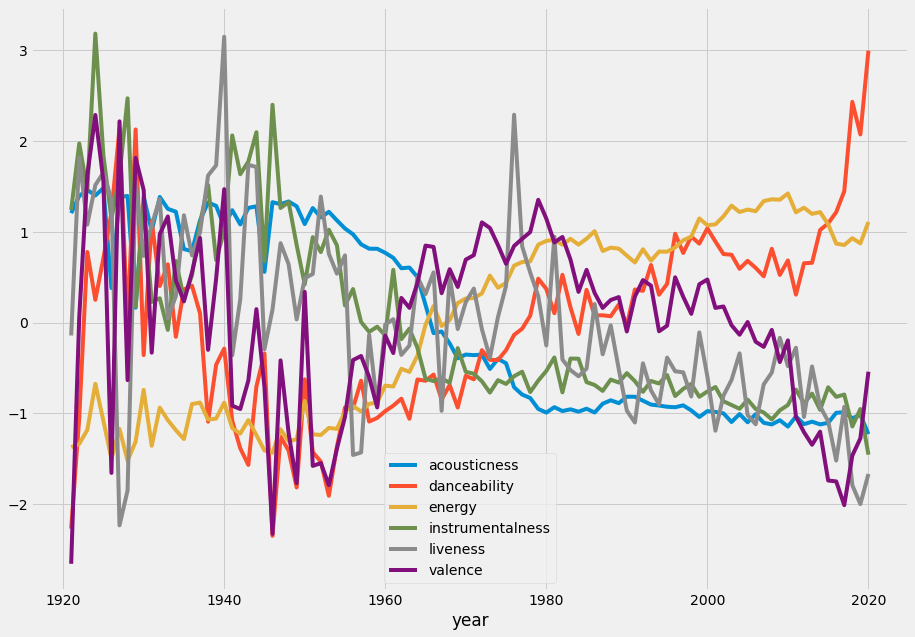

In [37]:
graph_data[["acousticness","danceability","energy", 
         "instrumentalness", "liveness", "valence","year"]].set_index('year').plot(kind='line',figsize=(14,10))

comments: General EDA, not very useful in producing meaningful insight. Moving forward, I will explore more trends related to the problem satement

### show how duration of music has shorten over time

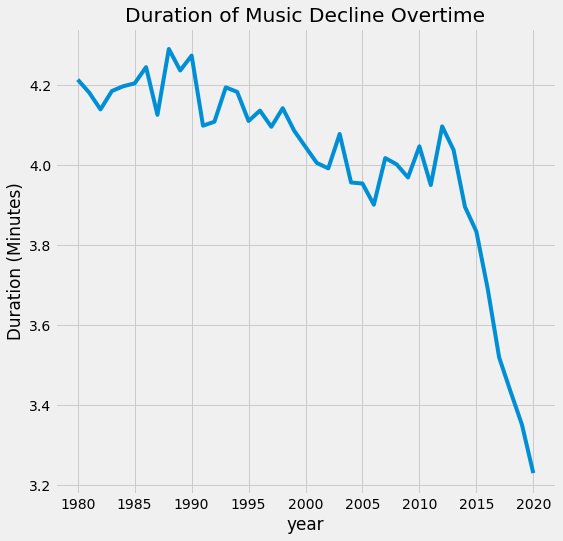

In [50]:
#plot the duration of songs in minute across time
plt.figure(figsize=(8,8))
(data_by_year_df[(data_by_year_df.year >= 1980)].groupby('year')['duration_ms'].mean()/60000).plot() #group data by year, take the average duration per year and plot
plt.ylabel('Duration (Minutes)')
plt.title('Duration of Music Decline Overtime')
plt.savefig('../images/duration-of-music-decline-overtime.png',bbox_inches='tight');

In [51]:
(data_by_year_df.groupby('year')['duration_ms'].mean()/60000)

year
1921    4.342286
1922    2.757829
1923    2.965706
1924    3.184112
1925    3.083115
          ...   
2016    3.689942
2017    3.518595
2018    3.433350
2019    3.350413
2020    3.228807
Name: duration_ms, Length: 100, dtype: float64

shorter duration in songs shows that artist or incentivised to make shorter songs for more plays as they are paid per stream. Can also reflect music listener's shortened attentions span. 


In [52]:
data_by_year_df[(data_by_year_df['year'] >= 2011) & (data_by_year_df['year'] <= 2020)].groupby('year')

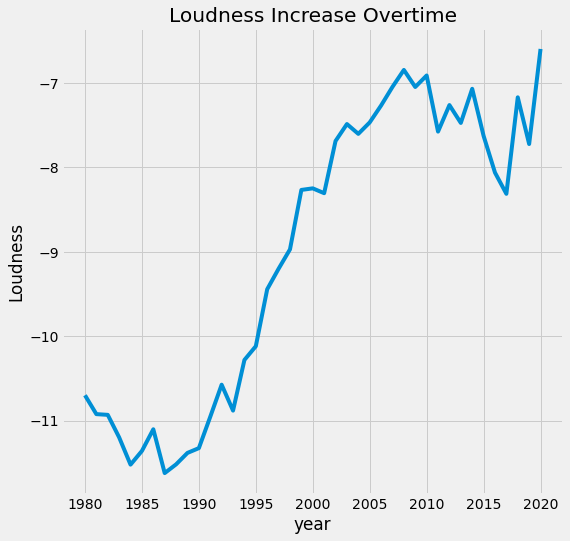

In [53]:
plt.figure(figsize=(8,8))
data_by_year_df[(data_by_year_df.year >= 1980)].groupby('year')['loudness'].mean().plot() #group data by year, take the average duration per year and plot
plt.ylabel('Loudness')
plt.title('Loudness Increase Overtime')
plt.savefig('../images/loudness-increase-overtime',bbox_inches='tight');


-  Loudness, the inherent volume of the music itself, before any adjustments by the listener.
- dynamic range becomes much more restricted. As in, the contrast between the really soft stuff, and the really loud stuff shrinks, so the overall emotional impact of the music is reduced.

In [54]:
#checking for unique key in each year
data_by_year_df.key.unique()

array([ 2, 10,  0,  5,  9,  7,  1])

In [55]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155098 entries, 0 to 155097
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           155098 non-null  float64
 1   year              155098 non-null  int64  
 2   acousticness      155098 non-null  float64
 3   artists           155098 non-null  object 
 4   danceability      155098 non-null  float64
 5   duration_ms       155098 non-null  int64  
 6   energy            155098 non-null  float64
 7   explicit          155098 non-null  int64  
 8   id                155098 non-null  object 
 9   instrumentalness  155098 non-null  float64
 10  key               155098 non-null  int64  
 11  liveness          155098 non-null  float64
 12  loudness          155098 non-null  float64
 13  mode              155098 non-null  int64  
 14  name              155098 non-null  object 
 15  popularity        155098 non-null  int64  
 16  release_date      15

In [56]:
#convert key data into string 
data_df.key = data_df.key.apply(lambda x: str(x))

In [57]:
#group songs by year to see variance in key
data_df.groupby('year')['key'].unique()

year
1921    [7, 3, 5, 2, 0, 1, 8, 9, 10, 4, 11, 6]
1922    [0, 1, 7, 4, 6, 2, 5, 8, 10, 11, 9, 3]
1923    [8, 4, 3, 0, 5, 10, 2, 7, 9, 1, 11, 6]
1924    [2, 3, 8, 0, 10, 7, 5, 9, 1, 6, 4, 11]
1925    [3, 8, 5, 9, 0, 2, 7, 10, 6, 1, 4, 11]
                         ...                  
2016    [6, 8, 0, 10, 1, 5, 7, 9, 4, 3, 11, 2]
2017    [0, 8, 7, 11, 9, 6, 10, 5, 1, 4, 3, 2]
2018    [0, 6, 3, 4, 7, 11, 8, 2, 1, 10, 5, 9]
2019    [0, 2, 10, 8, 1, 7, 5, 4, 6, 11, 3, 9]
2020    [7, 6, 1, 0, 4, 10, 9, 5, 11, 8, 2, 3]
Name: key, Length: 100, dtype: object

In [58]:
#show value count of keys in proportion to overall count for spread of data
data_df[data_df['year'] == 2020]['key'].value_counts(normalize =True)

1     0.135634
0     0.105294
7     0.100535
11    0.092802
5     0.090422
6     0.086258
2     0.078525
10    0.076740
8     0.076740
9     0.070196
4     0.065437
3     0.021416
Name: key, dtype: float64

In [62]:
#list of variance per year
variance = []

for year in data_df.year.unique():
    #create normalized value count
    normal_data = data_df[data_df['year'] == year]['key'].value_counts(normalize =True)
    # calculate variance
    variance_val = ((normal_data - normal_data.mean())**2).sum()/(len(normal_data)-1)
    #append cariance to list
    variance.append(variance_val)
        

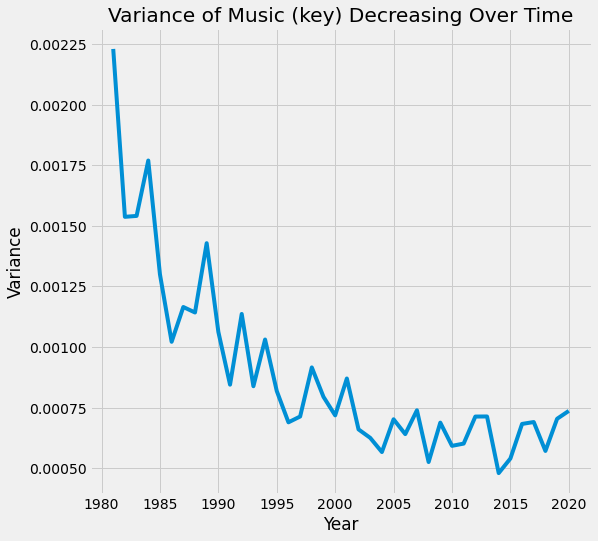

In [63]:
plt.figure(figsize=(8,8))
plt.ylabel('Variance')
plt.xlabel('Year')
plt.title('Variance of Music (key) Decreasing Over Time')
#only show variance since 1980
sns.lineplot(y=variance[60:101], x=data_df.year.unique()[60:101])
plt.savefig('../images/variance-of-music-decreasing-over-time',bbox_inches='tight');

Key or pitch includ details about harmony, melody, chords, and progressions – essentially how the notes were arranged and unfolded over the course of the song.

Data suggested that the variety of pitch progressions used has shrunk over the years. In other words, musicians are becoming less inventive and adventurous in how they get from one note or chord to the next, and instead seem to be relying more and more on the same sequences and patterns that others have used successfully in the past.

## Clustering Songs Together

One of the limitations of content based recommendations, as with others, that it is still known to create a filter bubble. However because the content we are recommending is music based on just audio features, there is still a possibility for recommendations to not be the same genre, epoch or language.

How we can prove this is by clustering the song data. 

### Visualise Songs

In [69]:
#create subset of data for illustrative and clustering purposes
cluster_df = data_df.sample(20000, random_state=42)

#scale data
def scaler(data):
    ss = StandardScaler()
    return ss.fit_transform(data)

cluster_df_scaled = scaler(cluster_df.drop(columns = ['year','id','popularity','explicit','main_artist','feat_artist','release_date','name','artists']))

What is tsne? 

Use to understand high-dimensional data and project it into low-dimensional space (2D).


In [65]:
# initiate the model
tsne = TSNE(learning_rate= 100, perplexity = 100)

# fit the model an transform the data
cluster_tsne = tsne.fit_transform(cluster_df_scaled)


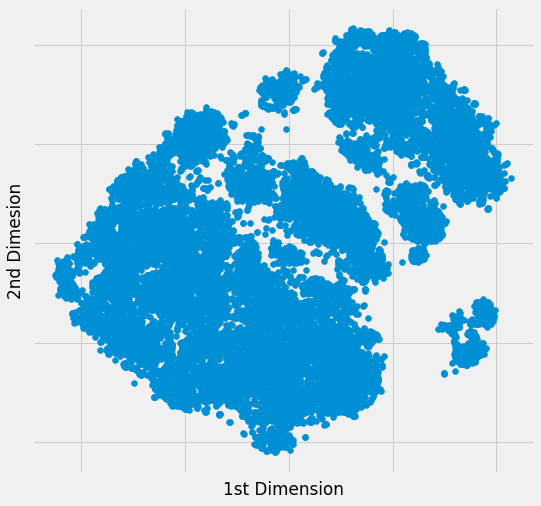

In [55]:
# plot tsne results
plt.figure(figsize=(8,8))

plt.scatter(cluster_tsne[:,0], cluster_tsne[:,1])

plt.ylabel("2nd Dimesion")
plt.xlabel("1st Dimension")

ax = plt.gca()

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.grid(True)

plt.savefig('../images/tsne', bbox_inches='tight')
plt.show();

Looks like there are definitely some clusters. I also expect KMeans to perform better than DBSCAN based on the globular shape of the t-SNE results.

### Finding optimal K using elbow method

Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible

In [56]:

K = range(1,21)
distortion = [] #the sum of square error for each data point to their nearest cluster centre
# using for loop
for k in K:
    inertia = KMeans(n_clusters=k).fit(cluster_df_scaled).inertia_
    distortion.append(inertia)



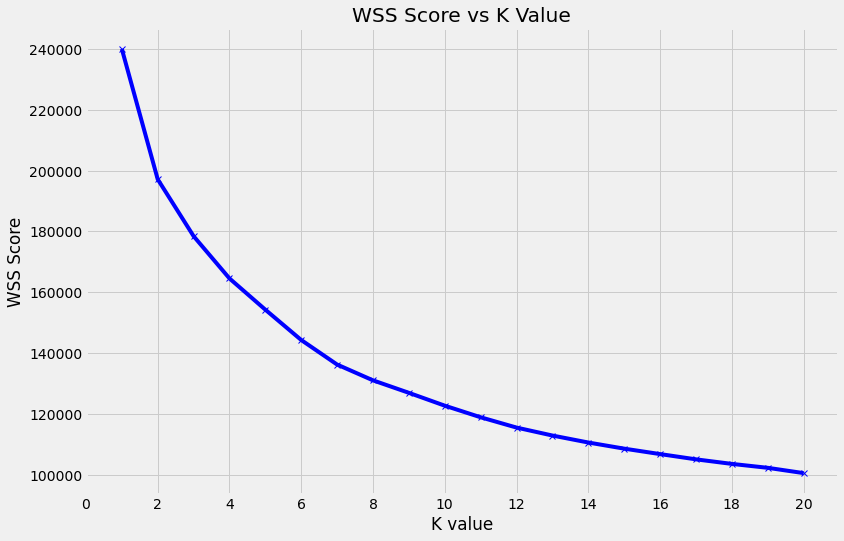

In [57]:
#plot for distortion against k range 50 to select best K
plt.figure(figsize = (12,8))
plt.plot(K, distortion,'bx-')
plt.xticks(np.arange(0,22,2), np.arange(0,22,2))
plt.xlabel('K value')
plt.ylabel('WSS Score')
plt.title('WSS Score vs K Value')
plt.savefig('../images/elbow-method',bbox_inches='tight');

We see that the elbow is at K =8, where the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 8.

In [66]:
#reasign kmean's prediction
km_model = KMeans(n_clusters=8,random_state=42).fit(cluster_df_scaled)
grouped_genre = km_model.predict(cluster_df_scaled)

In [70]:
silhouette_score(cluster_df_scaled, km_model.labels_)

NameError: name 'silhouette_score' is not defined

In [ ]:
cluster_df['km_grouped_genre'] = grouped_genre

Now that we have clustered a sample of our songs, I would like to if see how an artist like Johann Sebastian Bach, a renown classical composer, would be clustered in just more than 1 cluster.

In [ ]:
bach = cluster_df[cluster_df.main_artist == "Johann Sebastian Bach"].groupby('km_grouped_genre').count().reset_index()

# plot results
plt.figure(figsize = (12,8))
plot = plt.bar(bach["km_grouped_genre"].unique(), bach["name"].sort_values())
plt.xlabel('K-Means Cluster')
plt.ylabel('Frequency')
plt.title('Bach Songs')
plt.xticks(np.arange(1,9), np.arange(1,9))
plt.savefig('../images/bach-songs', bbox_inches='tight');


We can observe a clear tendency of his music towards cluster 3. However this still higlights that by recommending solely of audio features,  The boundaries of music are fluid, and songs from different genres would be neighbours in a given feature space. 

However even though we can predict there may be different types of genre within a cluster, 

I would still be using cosine similarity in my recommender system, to consider song recommendation instead of of using a pairwise distance metric, as cosine similarity does not consider magnitude in its similarity measurement rather than the euclidean distance, and in theory this should result in recommendations from cluster and therefore different genre. 


In [62]:
data_df.to_csv('../data/spotify_songs_1922/cleaned_data.csv', index = False)